# Desafio Data Science Intelivix
  Por: [Paulo Romeira](https://github.com/pauloromeira)

In [1]:
# Classificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Pré-processamento de dados
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Treinamento
from sklearn.model_selection import RandomizedSearchCV
# Código retirado da versão: v0.19.dev0, com pequeno ajuste
from sklearn_dev import RepeatedStratifiedKFold

# Métricas
from sklearn.metrics import classification as class_metrics

# Outros
import numpy as np
import pandas as pd
import utils

# Dataset
# from sklearn.datasets import load_iris

# Random state: seed para que o notebook possa ser reproduzido.
R_STATE = 1

# Dataset

In [2]:
# Easy way :)
# iris = load_iris()
# X, y = iris.data, iris.target

header_names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class']
ds = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                 header=None,
                 names=header_names
                )

ds.groupby('class').first()

,sepal length,sepal width,petal length,petal width
class,,,,
Iris-setosa,5.1,3.5,1.4,0.2
Iris-versicolor,7.0,3.2,4.7,1.4
Iris-virginica,6.3,3.3,6.0,2.5


## Pré-processamento dos dados

In [3]:
# Mapeia as classes para números
encoder = LabelEncoder()

# Normaliza os atributos para valores entre 0 e 1
scaler = MinMaxScaler()

# Apenas as variáveis X e y serão usadas daqui em diante
X = scaler.fit_transform(ds[header_names[:-1]])
y = encoder.fit_transform(ds['class'])

# Classificadores e intervalos de hiperparâmetros
* Obs: é possível acrescentar novos classificadores e parâmetros nesta seção, sem a necessidade de alterar o resto do código.

In [4]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    LogisticRegression()
]

classifiers_names = ['Nearest Neighbors', 'Support Vector Classifier', 'Logistic Regression']

# Definindo os valores possíveis dos hiperparâmetros dos classificadores
params = [
    { 'n_neighbors': range(1, 50), 'weights': ['uniform', 'distance'] }, # KNN
    { 'kernel':('linear', 'rbf'), 'C': np.linspace(0.001, 10, 10000) }, # SVC
    { 'C': range(1,1000) } # L. Regression
]

## Otimização de hiperparâmetros

In [5]:
# Os dados são divididos em 3 (33% para validação) randomicamente e de forma balanceada,
# e o processo é repetido 'n_repeats' vezes.
cross_validator = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=R_STATE)

for classifier, name, param in zip(classifiers, classifiers_names, params):
    # Aqui, cada classificador é testado em cross-validation pelo RandomizedSearchCV,
    # para cada combinação randômica dos parâmetros.
    grid = RandomizedSearchCV(classifier, param, scoring='accuracy',
                              cv=cross_validator, random_state=R_STATE).fit(X, y)

    # Seta parâmetros achados no gridsearch
    classifier.set_params(**grid.best_params_)
    
    print('{0}: {1} - {2:.2%}'.format(name, grid.best_params_, grid.best_score_))

Nearest Neighbors: {'weights': 'distance', 'n_neighbors': 14} - 95.85%
Support Vector Classifier: {'kernel': 'linear', 'C': 6.0870000000000006} - 96.51%
Logistic Regression: {'C': 929} - 95.62%


> Na busca pelos melhores parâmetros acima, o classificador que obteve melhor desempenho no cross-validation foi o _SVC_, com 96.51% na média de acertos.

## Treinamento dos classificadores

Com os hiperparâmetros definidos, os classificadores são treinados e testados massivamente, com diferentes combinações da amostra, mas sempre na proporção 66.66% para treinamento e 33.33% para testes.

A cada treinamento de um classificador, os valores obtidos são inseridos em y_preds, uma lista de listas para cada classificador.  
Os valores reais são inseridos em y_true.

In [6]:
# Esta função divide os dados randomicamente, na proporção definida por 'n_splits',
# treina os classificadores em cross-validation e repete o processo 'n_repeats' vezes.
def massive_training(classifiers, X, y, n_splits=3, n_repeats=10):
    y_true = []
    y_preds = [[] for _ in classifiers]
    
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=R_STATE)
    
    for i_train, i_test in cv.split(X, y):
        X_train, X_test = X[i_train], X[i_test]
        y_train, y_test = y[i_train], y[i_test]

        y_true.extend(y_test)
        for j, classifier in enumerate(classifiers):
            classifier.fit(X_train, y_train)
            y_preds[j].extend(classifier.predict(X_test))
    
    return y_true, y_preds

y_true, y_preds = massive_training(classifiers, X, y, n_repeats=1000)

# Análise dos classificadores

## Matrizes de confusão

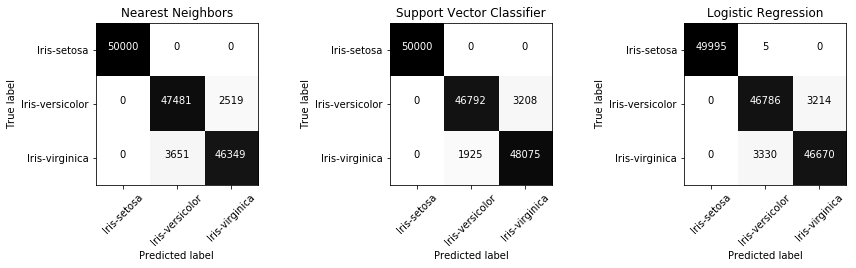

In [7]:
%matplotlib inline

cms = [class_metrics.confusion_matrix(y_true, y_pred) for y_pred in y_preds]
utils.plot_confusion_matrices(cms, encoder.classes_, titles=classifiers_names)

## Relatórios

In [8]:
for c_name, y_pred in zip(classifiers_names, y_preds):
    print('*** {0}: {1:.2%} ***'.
          format(c_name, class_metrics.accuracy_score(y_true, y_pred)))
        
    print('Report:')
    print(class_metrics
          .classification_report(y_true, y_pred, target_names=encoder.classes_, digits=4))
    print()

*** Nearest Neighbors: 95.89% ***
Report:
                 precision    recall  f1-score   support

    Iris-setosa     1.0000    1.0000    1.0000     50000
Iris-versicolor     0.9286    0.9496    0.9390     50000
 Iris-virginica     0.9485    0.9270    0.9376     50000

    avg / total     0.9590    0.9589    0.9589    150000


*** Support Vector Classifier: 96.58% ***
Report:
                 precision    recall  f1-score   support

    Iris-setosa     1.0000    1.0000    1.0000     50000
Iris-versicolor     0.9605    0.9358    0.9480     50000
 Iris-virginica     0.9374    0.9615    0.9493     50000

    avg / total     0.9660    0.9658    0.9658    150000


*** Logistic Regression: 95.63% ***
Report:
                 precision    recall  f1-score   support

    Iris-setosa     1.0000    0.9999    0.9999     50000
Iris-versicolor     0.9335    0.9357    0.9346     50000
 Iris-virginica     0.9356    0.9334    0.9345     50000

    avg / total     0.9563    0.9563    0.9563    150000